In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

img_size = 32 #resize the MNIST images to this dimension 

#dataloader
from torch.utils.data import DataLoader
batch_size = 32

# #to circumvent the HTTP error (does not work)
# import urllib
# basepath = './content/drive/My Drive/'
# def set_header_for(url, filename):
#     opener = urllib.request.URLopener()
#     opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
#     opener.retrieve(
#     url, f'{basepath}/{filename}')

# set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


#dataloading
transform_train = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     ])

dataset = datasets.FashionMNIST(root='../data/FashionMNIST', train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('# training minibatches = %d'%len(train_loader))

cpu


0.7%

100.0%


Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw


100.6%

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



5.3%

100.0%


Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw


119.3%

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw
Processing...
Done!
# training minibatches = 1875


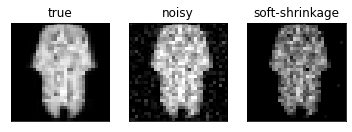

In [3]:
import matplotlib.pyplot as plt
#add noise, denoise using a prox. operator
noise_sd = 0.10
lambda_reg = 0.25
soft_shrink = nn.Softshrink(lambd=lambda_reg)

for idx, (images, labels) in enumerate(train_loader):
  x_true = images.to(device) #true images
  x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
  x_soft_shrink = soft_shrink(x_noisy)
  #see true, noisy, and denoised
  x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
  x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
  x_soft_shrink_im = x_soft_shrink[0,:,:].cpu().detach().numpy().squeeze()

  plt.subplot(131)
  vmin, vmax = x_true_im.min(), x_true_im.max()
  plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('true')

  plt.subplot(132)
  plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('noisy')

  plt.subplot(133)
  plt.imshow(x_soft_shrink_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('soft-shrinkage')

  plt.gcf().set_size_inches(6.0, 4.0)

  break

In [4]:
#unrolled gradient network
n_filters = 16
n_in_channels = 1
tau = 0.01*torch.ones(1).to(device)

class cnn_image_space(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=n_filters): #2 input channels, 1 for image, 1 for noisy data
        super(cnn_image_space, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)
        
    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return dx
    
class unrolled_gradient_model(nn.Module):
    def __init__(self, niter=5, tau=tau): #niter=10 worked quite well
        super(unrolled_gradient_model, self).__init__()
        
        self.niter = niter
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.cnn_image_layers = nn.ModuleList([cnn_image_space().to(device) for i in range(self.niter)])
        
    def forward(self, y): #y = noisy data
        x = y
        for iteration in range(self.niter):
            x = x - self.tau[iteration] * self.cnn_image_layers[iteration](x, y) # x = x - step_size*dx
        return x

net = unrolled_gradient_model().to(device)

epoch[1/10] mini-batch[200/1875] avg_prox_loss 2414.870994:


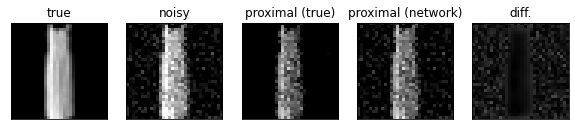

epoch[1/10] mini-batch[400/1875] avg_prox_loss 2241.304428:


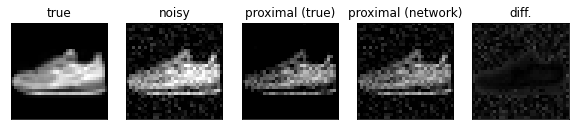

epoch[1/10] mini-batch[600/1875] avg_prox_loss 2179.364484:


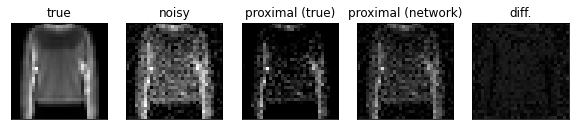

epoch[1/10] mini-batch[800/1875] avg_prox_loss 2087.138008:


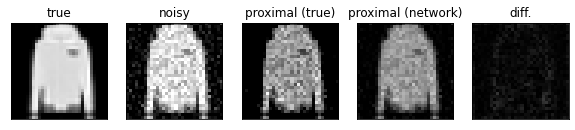

epoch[1/10] mini-batch[1000/1875] avg_prox_loss 2013.103637:


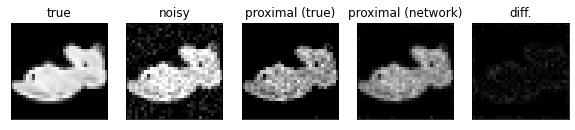

epoch[1/10] mini-batch[1200/1875] avg_prox_loss 1992.649626:


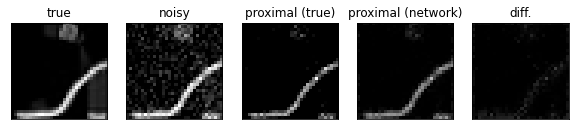

epoch[1/10] mini-batch[1400/1875] avg_prox_loss 1963.022224:


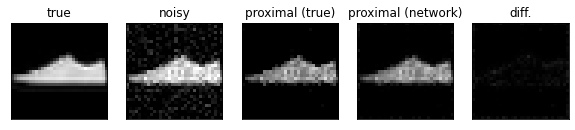

epoch[1/10] mini-batch[1600/1875] avg_prox_loss 1962.145837:


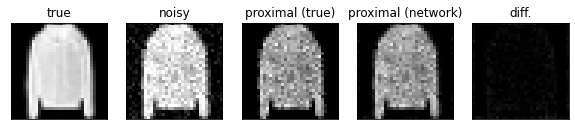

epoch[1/10] mini-batch[1800/1875] avg_prox_loss 1953.688969:


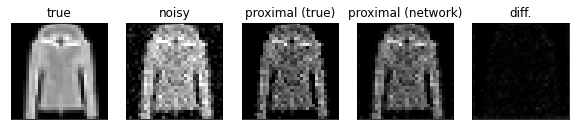

epoch[2/10] mini-batch[200/1875] avg_prox_loss 1963.174226:


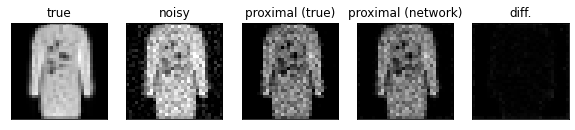

epoch[2/10] mini-batch[400/1875] avg_prox_loss 1949.348689:


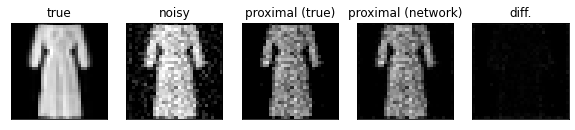

epoch[2/10] mini-batch[600/1875] avg_prox_loss 1959.530730:


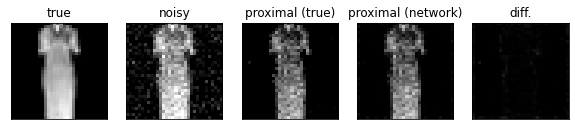

epoch[2/10] mini-batch[800/1875] avg_prox_loss 1957.760971:


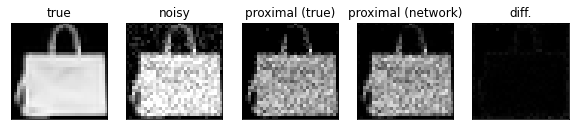

epoch[2/10] mini-batch[1000/1875] avg_prox_loss 1961.201463:


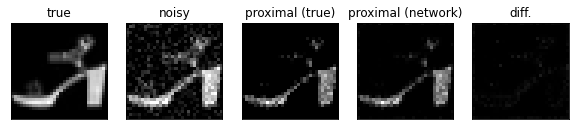

epoch[2/10] mini-batch[1200/1875] avg_prox_loss 1968.640174:


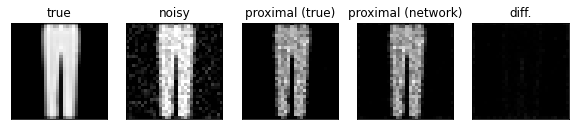

epoch[2/10] mini-batch[1400/1875] avg_prox_loss 1946.707989:


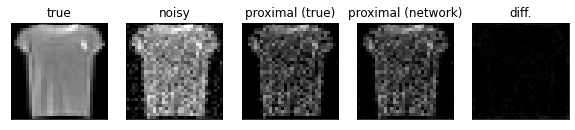

epoch[2/10] mini-batch[1600/1875] avg_prox_loss 1956.579489:


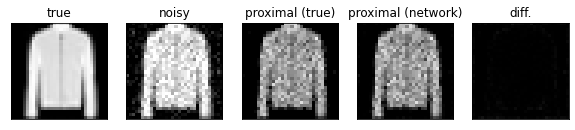

epoch[2/10] mini-batch[1800/1875] avg_prox_loss 1945.401259:


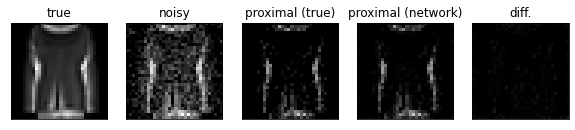

epoch[3/10] mini-batch[200/1875] avg_prox_loss 1953.303299:


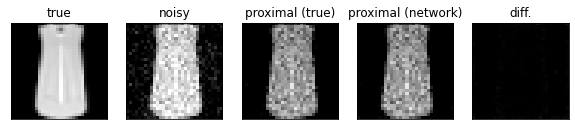

epoch[3/10] mini-batch[400/1875] avg_prox_loss 1965.919540:


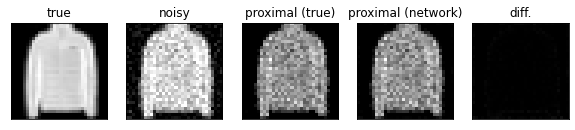

epoch[3/10] mini-batch[600/1875] avg_prox_loss 1943.178187:


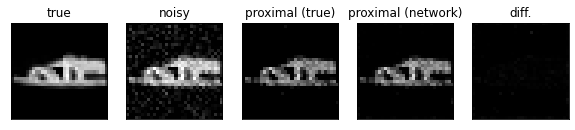

epoch[3/10] mini-batch[800/1875] avg_prox_loss 1927.352532:


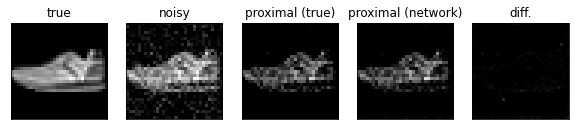

epoch[3/10] mini-batch[1000/1875] avg_prox_loss 1943.939693:


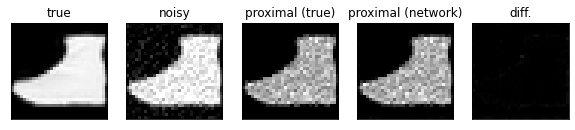

epoch[3/10] mini-batch[1200/1875] avg_prox_loss 1956.138589:


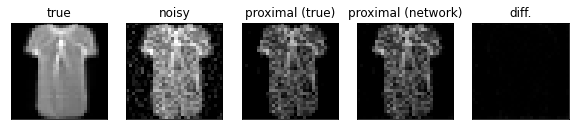

epoch[3/10] mini-batch[1400/1875] avg_prox_loss 1939.334037:


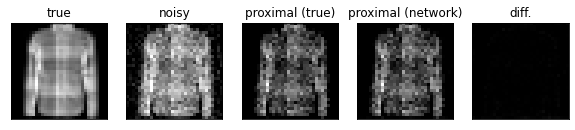

epoch[3/10] mini-batch[1600/1875] avg_prox_loss 1938.538207:


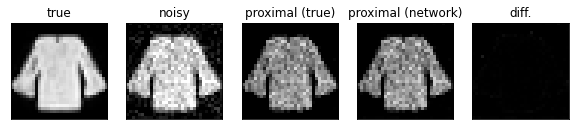

epoch[3/10] mini-batch[1800/1875] avg_prox_loss 1931.315665:


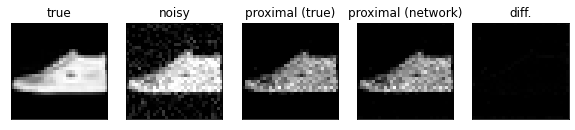

epoch[4/10] mini-batch[200/1875] avg_prox_loss 1943.622039:


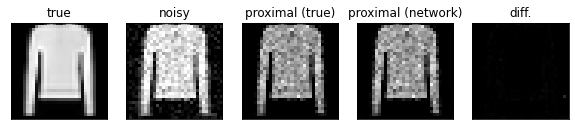

epoch[4/10] mini-batch[400/1875] avg_prox_loss 1938.066617:


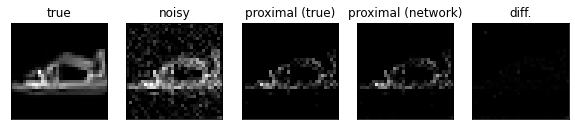

epoch[4/10] mini-batch[600/1875] avg_prox_loss 1959.413094:


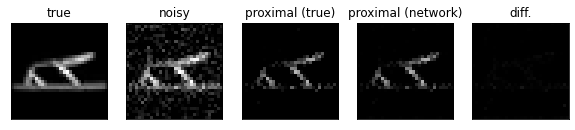

epoch[4/10] mini-batch[800/1875] avg_prox_loss 1922.847101:


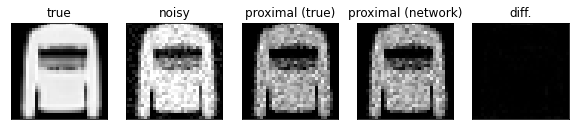

epoch[4/10] mini-batch[1000/1875] avg_prox_loss 1937.764095:


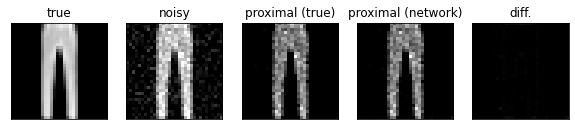

epoch[4/10] mini-batch[1200/1875] avg_prox_loss 1954.771117:


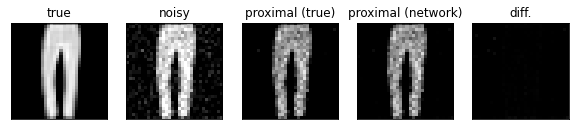

epoch[4/10] mini-batch[1400/1875] avg_prox_loss 1935.559293:


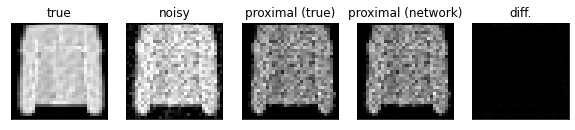

epoch[4/10] mini-batch[1600/1875] avg_prox_loss 1949.452640:


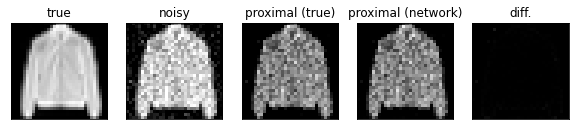

epoch[4/10] mini-batch[1800/1875] avg_prox_loss 1921.309659:


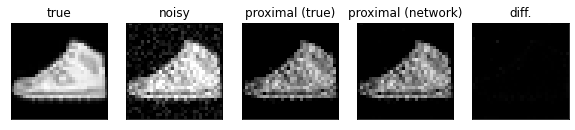

epoch[5/10] mini-batch[200/1875] avg_prox_loss 1945.155200:


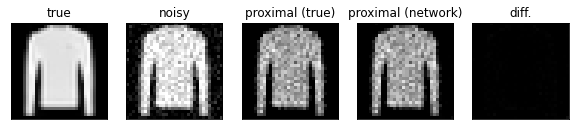

epoch[5/10] mini-batch[400/1875] avg_prox_loss 1953.161148:


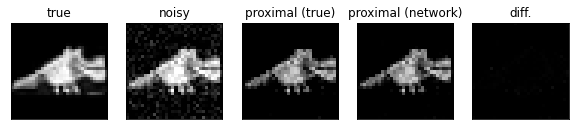

epoch[5/10] mini-batch[600/1875] avg_prox_loss 1933.635788:


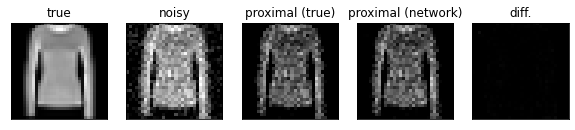

epoch[5/10] mini-batch[800/1875] avg_prox_loss 1932.538029:


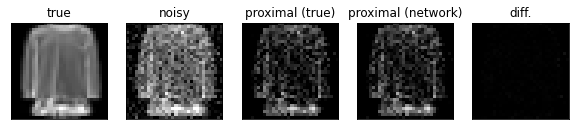

epoch[5/10] mini-batch[1000/1875] avg_prox_loss 1933.899231:


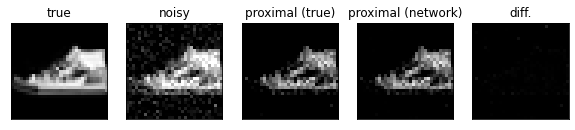

epoch[5/10] mini-batch[1200/1875] avg_prox_loss 1921.093181:


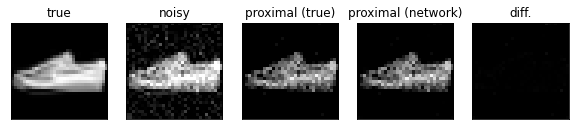

epoch[5/10] mini-batch[1400/1875] avg_prox_loss 1929.889993:


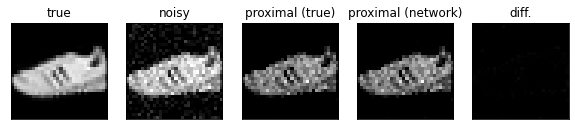

epoch[5/10] mini-batch[1600/1875] avg_prox_loss 1937.661332:


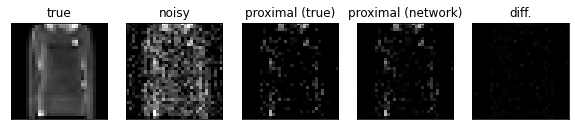

epoch[5/10] mini-batch[1800/1875] avg_prox_loss 1950.068360:


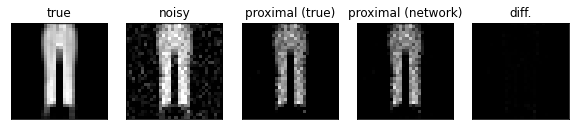

epoch[6/10] mini-batch[200/1875] avg_prox_loss 1954.581908:


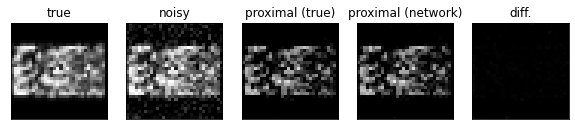

epoch[6/10] mini-batch[400/1875] avg_prox_loss 1937.719917:


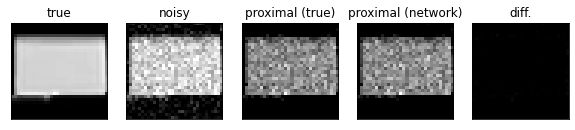

epoch[6/10] mini-batch[600/1875] avg_prox_loss 1928.301818:


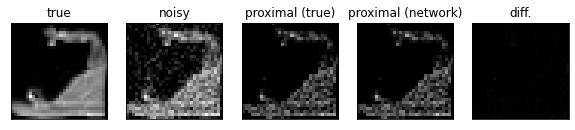

epoch[6/10] mini-batch[800/1875] avg_prox_loss 1913.737945:


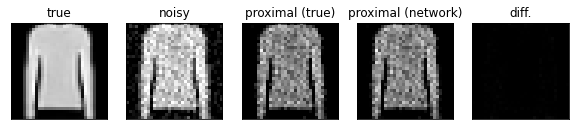

epoch[6/10] mini-batch[1000/1875] avg_prox_loss 1938.173765:


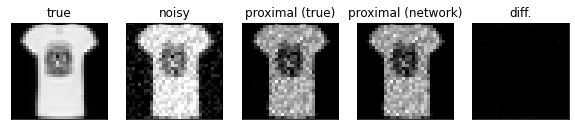

epoch[6/10] mini-batch[1200/1875] avg_prox_loss 1929.748825:


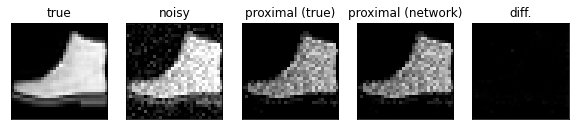

epoch[6/10] mini-batch[1400/1875] avg_prox_loss 1959.263267:


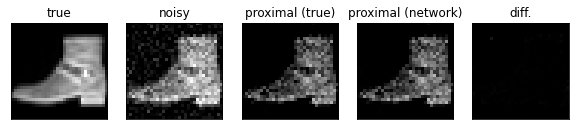

epoch[6/10] mini-batch[1600/1875] avg_prox_loss 1927.043499:


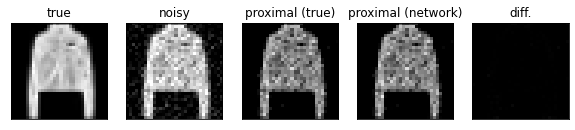

epoch[6/10] mini-batch[1800/1875] avg_prox_loss 1941.182396:


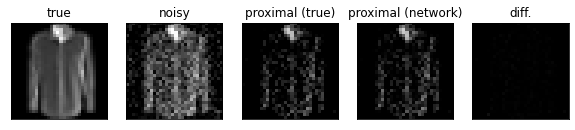

epoch[7/10] mini-batch[200/1875] avg_prox_loss 1933.677219:


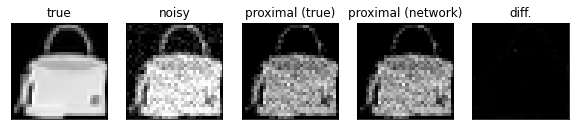

epoch[7/10] mini-batch[400/1875] avg_prox_loss 1928.954208:


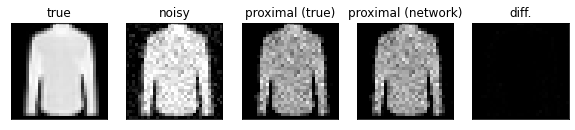

epoch[7/10] mini-batch[600/1875] avg_prox_loss 1936.051621:


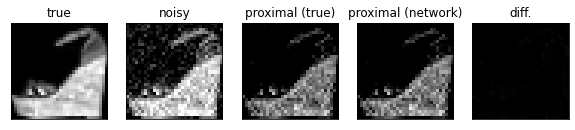

epoch[7/10] mini-batch[800/1875] avg_prox_loss 1935.851247:


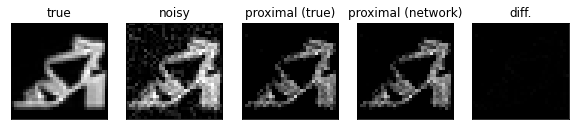

epoch[7/10] mini-batch[1000/1875] avg_prox_loss 1941.938636:


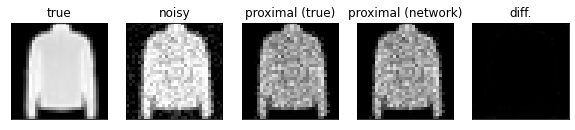

epoch[7/10] mini-batch[1200/1875] avg_prox_loss 1929.562190:


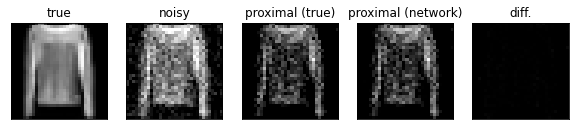

epoch[7/10] mini-batch[1400/1875] avg_prox_loss 1930.921304:


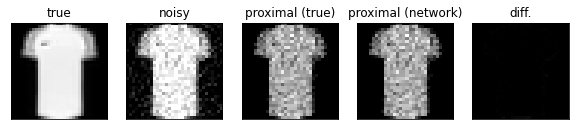

epoch[7/10] mini-batch[1600/1875] avg_prox_loss 1953.465416:


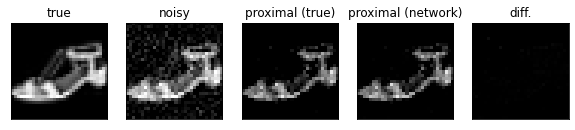

epoch[7/10] mini-batch[1800/1875] avg_prox_loss 1943.747825:


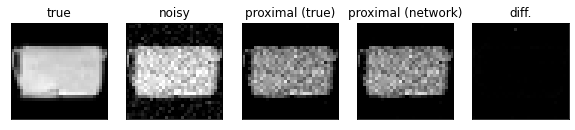

epoch[8/10] mini-batch[200/1875] avg_prox_loss 1940.291161:


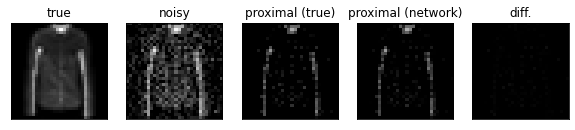

epoch[8/10] mini-batch[400/1875] avg_prox_loss 1940.404195:


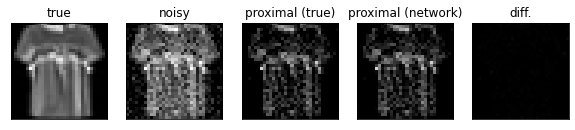

epoch[8/10] mini-batch[600/1875] avg_prox_loss 1946.251374:


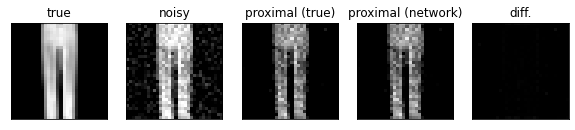

epoch[8/10] mini-batch[800/1875] avg_prox_loss 1935.937903:


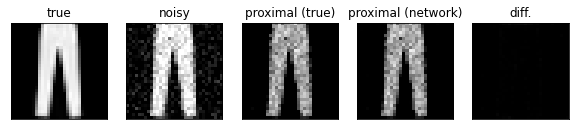

epoch[8/10] mini-batch[1000/1875] avg_prox_loss 1935.723554:


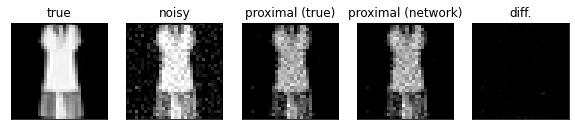

epoch[8/10] mini-batch[1200/1875] avg_prox_loss 1909.711699:


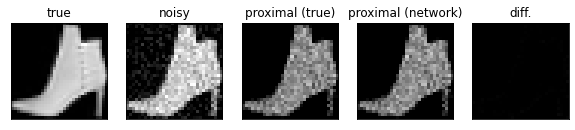

epoch[8/10] mini-batch[1400/1875] avg_prox_loss 1945.568945:


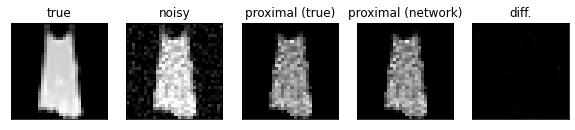

epoch[8/10] mini-batch[1600/1875] avg_prox_loss 1930.299509:


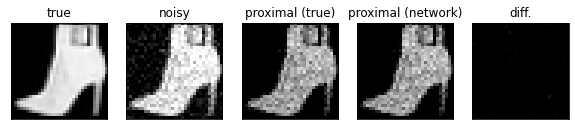

epoch[8/10] mini-batch[1800/1875] avg_prox_loss 1946.147836:


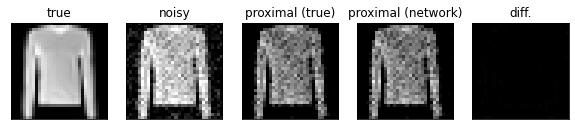

epoch[9/10] mini-batch[200/1875] avg_prox_loss 1939.970986:


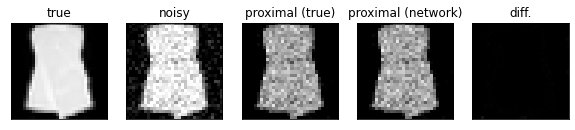

epoch[9/10] mini-batch[400/1875] avg_prox_loss 1943.666203:


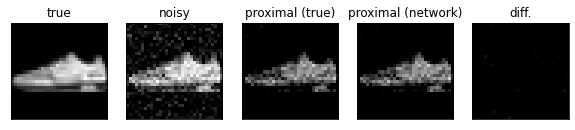

epoch[9/10] mini-batch[600/1875] avg_prox_loss 1933.047309:


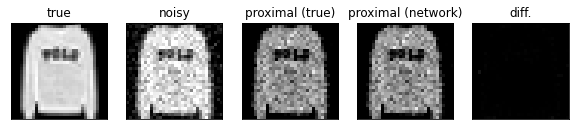

epoch[9/10] mini-batch[800/1875] avg_prox_loss 1911.698737:


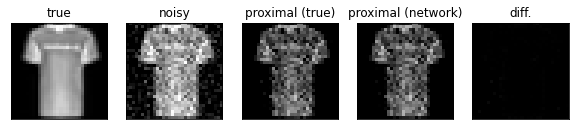

epoch[9/10] mini-batch[1000/1875] avg_prox_loss 1950.953758:


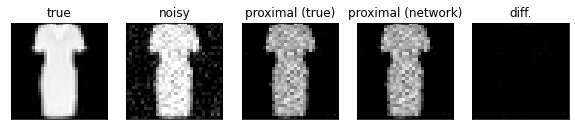

epoch[9/10] mini-batch[1200/1875] avg_prox_loss 1937.091471:


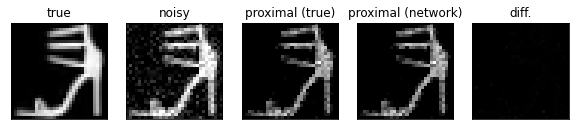

epoch[9/10] mini-batch[1400/1875] avg_prox_loss 1934.063267:


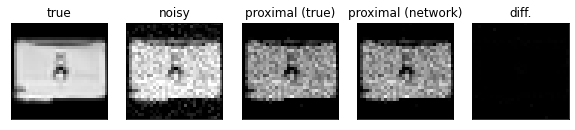

epoch[9/10] mini-batch[1600/1875] avg_prox_loss 1940.813387:


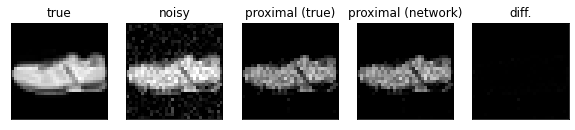

epoch[9/10] mini-batch[1800/1875] avg_prox_loss 1943.995195:


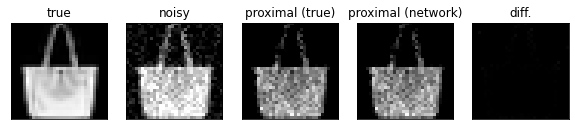

epoch[10/10] mini-batch[200/1875] avg_prox_loss 1964.760333:


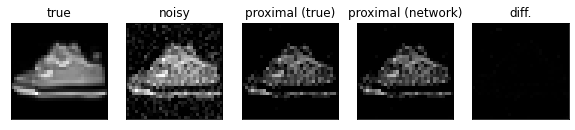

epoch[10/10] mini-batch[400/1875] avg_prox_loss 1949.148027:


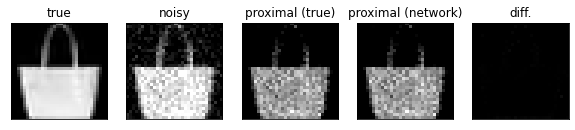

epoch[10/10] mini-batch[600/1875] avg_prox_loss 1941.715722:


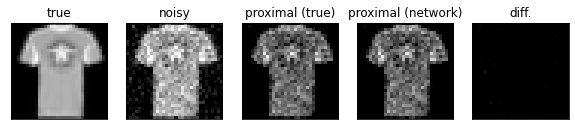

epoch[10/10] mini-batch[800/1875] avg_prox_loss 1941.239069:


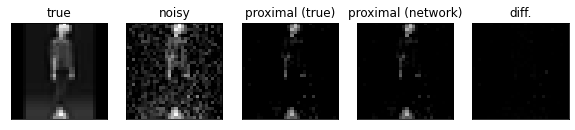

epoch[10/10] mini-batch[1000/1875] avg_prox_loss 1931.932185:


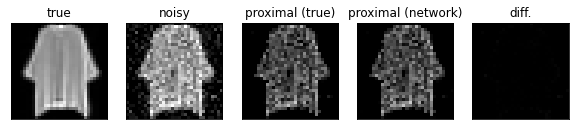

epoch[10/10] mini-batch[1200/1875] avg_prox_loss 1933.408857:


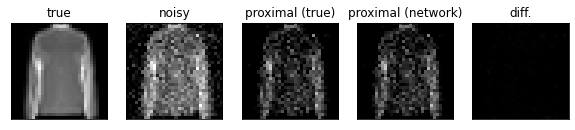

epoch[10/10] mini-batch[1400/1875] avg_prox_loss 1919.542935:


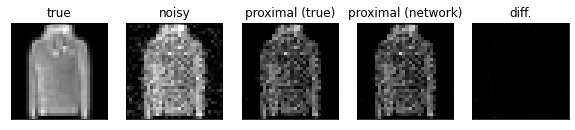

epoch[10/10] mini-batch[1600/1875] avg_prox_loss 1927.000142:


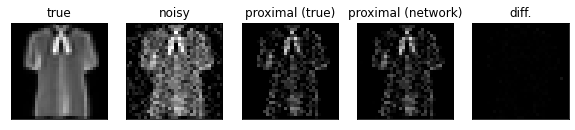

epoch[10/10] mini-batch[1800/1875] avg_prox_loss 1925.222557:


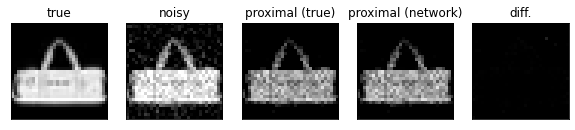

In [5]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9,0.99))

#main training loop
n_epochs = 10
num_minibatches = 200 #display the loss after these many mini-batches


for epoch in np.arange(n_epochs):
    total_prox_loss = 0.0
      
    for idx, (images, labels) in enumerate(train_loader):
        x_true = images.to(device) #true images
        x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
        x_soft_shrink = soft_shrink(x_noisy) #true output that we want the network to predict
        
        #optimize the net
        network_output = net(x_noisy)
        prox_loss = 0.5*torch.sum((network_output - x_noisy)**2) + lambda_reg*torch.sum(torch.abs(network_output)) #loss as a function of net parameters. net approximates arg_min_x (proximal obj)

        #update networks
        optimizer.zero_grad()
        prox_loss.backward()
        optimizer.step()

        total_prox_loss += prox_loss.item()

        if(idx % num_minibatches == num_minibatches-1):
            avg_prox_loss = total_prox_loss/num_minibatches
            
            print("epoch[{}/{}] mini-batch[{}/{}] avg_prox_loss {:.6f}:"\
                  .format(epoch+1, n_epochs, idx+1, len(train_loader), avg_prox_loss))
            total_prox_loss = 0.0
            
            #see true, noisy, and denoised for one image in the batch
            x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
            x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
            x_soft_shrink_im = x_soft_shrink[0,:,:].cpu().detach().numpy().squeeze()

            plt.subplot(151)
            vmin, vmax = x_true_im.min(), x_true_im.max()
            plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('true')

            plt.subplot(152)
            plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('noisy')

            plt.subplot(153)
            plt.imshow(x_soft_shrink_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('proximal (true)')

            plt.subplot(154)
            x_soft_shrink_net_im = network_output[0,:,:].cpu().detach().numpy().squeeze()
            plt.imshow(x_soft_shrink_net_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('proximal (network)')

            plt.subplot(155)
            diff_image = np.abs(x_soft_shrink_net_im-x_soft_shrink_im)
            plt.imshow(diff_image,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('diff.')

            plt.gcf().set_size_inches(10.0, 4.0)
            plt.show()

In [8]:
#save the models
pretrained_network_path = '../models/unrolled_gradient_pretrained_nets/'
os.makedirs(pretrained_network_path, exist_ok=True)
torch.save(net.state_dict(),  pretrained_network_path + "l1prox_model_" + 'epoch_%02d'%epoch + ".pt") 